<a href="https://colab.research.google.com/github/bsenst/dataverse/blob/main/load_object_detection_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
! unzip /content/drive/MyDrive/analyticsvidhya/train.zip
print(len(os.listdir("train/images")))
! unzip /content/drive/MyDrive/analyticsvidhya/test_niF99zC.zip
print(len(os.listdir("test/images")))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/analyticsvidhya/train.zip
replace train/labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 674
Archive:  /content/drive/MyDrive/analyticsvidhya/test_niF99zC.zip
replace test/images/900.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 557


In [2]:
import pandas as pd
labels = pd.read_csv("/content/train/labels.csv")
labels.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax
0,1.jpg,pothole,0,131,140,263
1,1.jpg,pothole,168,487,279,449
2,1.jpg,pothole,1,144,34,109
3,2.jpg,pothole,57,952,271,505
4,3.jpg,pothole,225,416,292,439


# show image with boxes

In [3]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


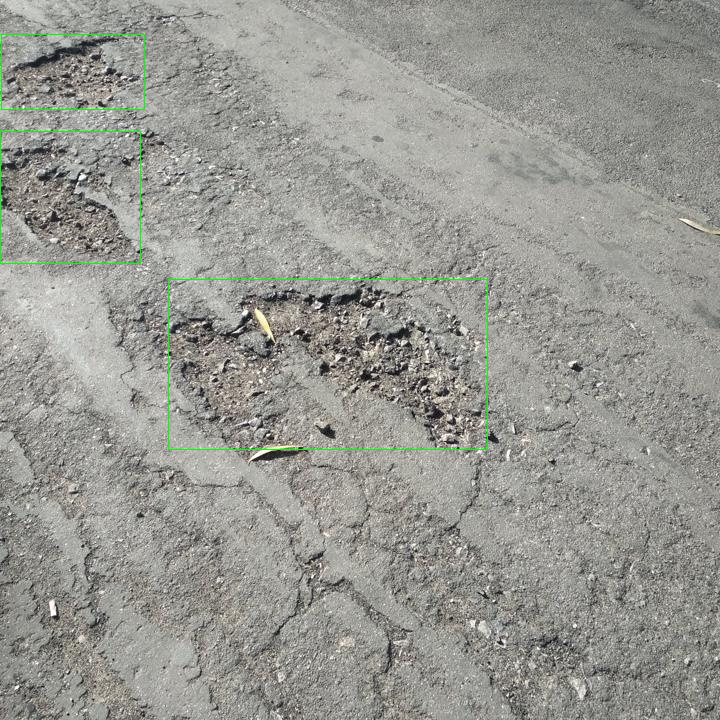

In [4]:
# https://github.com/rmalav15/visualize-voc-format-data/blob/master/main.py
from google.colab.patches import cv2_imshow
import cv2

image = cv2.imread("train/images/1.jpg")
box_color = (0, 255, 0)  #Green
image = cv2.rectangle(image, (168, 279), (487, 449), box_color)
image = cv2.rectangle(image, (0, 131), (140, 263), box_color)
image = cv2.rectangle(image, (1, 34), (144, 109), box_color)

cv2_imshow(image)

In [5]:
# https://pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/
# import the necessary packages
import os
# define the base path to the input dataset and then use it to derive
# the path to the images directory and annotation CSV file
BASE_PATH = "."
IMAGES_PATH = os.path.sep.join([BASE_PATH, "train/images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "train/labels.csv"])

In [6]:
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training plot,
# and testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])

In [7]:
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 25
BATCH_SIZE = 32

In [8]:
# pip install pyimagesearch

In [9]:
# import the necessary packages
# from pyimagesearch import config
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# load images

In [43]:
# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
rows = open(ANNOTS_PATH).read().strip().split("\n")
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
filenames = []

print(rows[1:5])

# loop over the rows
for row in rows[1:]:
    # break the row into the filename and bounding box coordinates
    row = row.split(",")
    filename = row[0]
    startX, endX, startY, endY = row[2:]

    # derive the path to the input image, load the image (in OpenCV
    # format), and grab its dimensions
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]
    # scale the bounding box coordinates relative to the spatial
    # dimensions of the input image
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h

    # load the image and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)

[INFO] loading dataset...
['1.jpg,pothole,0,131,140,263', '1.jpg,pothole,168,487,279,449', '1.jpg,pothole,1,144,34,109', '2.jpg,pothole,57,952,271,505']


In [45]:
filenames[:5], len(filenames)

(['1.jpg', '1.jpg', '1.jpg', '2.jpg', '3.jpg'], 1371)

In [48]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
# targets = np.array(targets, dtype="float32")
targets = np.array(targets, dtype="float32")
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10,
	random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]
# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
! mkdir output
f = open(TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...
mkdir: cannot create directory ‘output’: File exists


# create model

In [49]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

In [51]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

[INFO] saving object detector model...


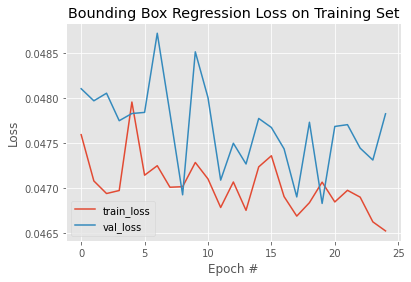

In [52]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# plot the model training history
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

In [53]:
# import the necessary packages
# from pyimagesearch import config
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import imutils
import cv2
import os

# predict on test images

In [54]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,
# 	help="path to input image/text file of image filenames")
# args = vars(ap.parse_args())
args = "test/images"

In [72]:
# determine the input file type, but assume that we're working with
# single input image
# filetype = mimetypes.guess_type(args["input"])[0]
filetype = "text/plain"
# imagePaths = [args["input"]]
imagePaths = "test/images"
# if the file type is a text file, then we need to process *multiple*
# images
if "text/plain" == filetype:
	# load the filenames in our testing file and initialize our list
	# of image paths
	# filenames = open(args["input"]).read().strip().split("\n")
	filenames = os.listdir("test/images")[1:]
	imagePaths = []
	# loop over the filenames
	for f in filenames:
		# construct the full path to the image filename and then
		# update our image paths list
		# p = os.path.sep.join([IMAGES_PATH, f])
		p = os.path.sep.join(["test/images", f])
		if p[-4:] == ".jpg":
			imagePaths.append(p)
imagePaths[:5]

['test/images/782.jpg',
 'test/images/959.jpg',
 'test/images/684.jpg',
 'test/images/1079.jpg',
 'test/images/1071.jpg']

[INFO] loading object detector...
[0.20392157 0.5137255  0.8862745 ]
1/1 [==============================] - 0s 209ms/step
[[0.32052058 0.40777957 0.6437461  0.5707262 ]]


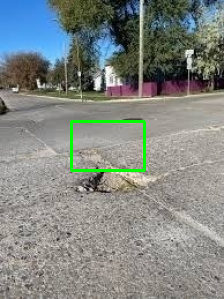

[0.48235294 0.47843137 0.49803922]
1/1 [==============================] - 0s 24ms/step
[[0.35821632 0.4244258  0.64180213 0.61643195]]


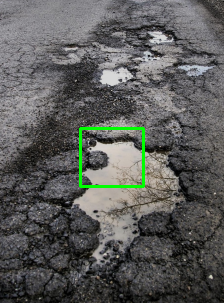

[0.69411767 0.6666667  0.627451  ]
1/1 [==============================] - 0s 34ms/step
[[0.32672504 0.37153402 0.6330704  0.5955591 ]]


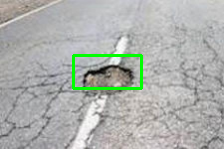

In [94]:
# As a substitution, consider using
from google.colab.patches import cv2_imshow

# load our trained bounding box regressor from disk
print("[INFO] loading object detector...")
model = load_model(MODEL_PATH)
# loop over the images that we'll be testing using our bounding box
# regression model
for imagePath in imagePaths[400:403]:
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    print(image[0][0][0])
    # make bounding box predictions on the input image
    pred = model.predict(image)
    print(pred)
    (startX, startY, endX, endY) = pred[0]
    # load the input image (in OpenCV format), resize it such that it
    # fits on our screen, and grab its dimensions
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=224)
    (h, w) = image.shape[:2]
    # scale the predicted bounding box coordinates based on the image
    # dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)
    # draw the predicted bounding box on the image
    cv2.rectangle(image, (startX, startY), (endX, endY),
      (0, 255, 0), 2)
    # show the output image
    cv2_imshow(image)
    cv2.waitKey(0)